# Models for the Zindi-Landslide-Competition

A description of the data can be found in the notebook EDA.

The metric for this competition is the f1-score.

My final score on the private leaderboard is 0.75607, which ranked: 20/173.
The top score for this competition is 0.76944.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.ensemble import StackingClassifier, HistGradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

## Preprocessing

As seen in the EDA, the twi-feature is highly skewed and the aspect-feature is circular. These columns of these features have to be transformed for usage in machine-learning algorithms.

The preprocessing includes:
* log transformation of twi-feature
* cos/sin transformation of aspect-feature
* selecting relevant columns
* standard scaling

In [2]:
# load data
train = pd.read_csv('data/Train.csv')
test = pd.read_csv('data/Test.csv')

In [3]:
# log-transform of columns
def log_transform(df, column):
    for col in df.columns:
        if column in col:
            result = np.where(df[col]>1.0e-5, df[col], 1.0e-5)
            df[col+'_log'] = np.log(result)

In [4]:
# using log_transform on twi columns of train and test set
log_transform(train, 'twi')
log_transform(test, 'twi')

In [5]:
# sine/cosine of circular-columns
def angle_transform(df, column):
    for col in df.columns:
        if column in col:
            df[col+'_sin'] = np.sin(np.deg2rad(df[col]))
            df[col+'_cos'] = np.cos(np.deg2rad(df[col]))

In [6]:
# using angle_transform on aspect columns of train and test set
angle_transform(train, 'aspect')
angle_transform(test, 'aspect')

In [7]:
# select all columns of specific features including the transformed columns of twi and aspect
selected_cols = []
selected_features = ['elevation', 'slope', 'aspect_sin', 'aspect_cos',
                     'placurv', 'procurv', 'lsfactor', 'twi_log', 'geology', 'sdoif']
for col in train.columns:
    for feature in selected_features:
        if feature in col:
            selected_cols.append(col)

In [8]:
# select columns used for x (features) and y (result) in modelling
X = train[selected_cols]
y = train.Label

# Split training data into train and validation sets with similar ratio of the label
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3, random_state=2022, stratify=y)

In [9]:
# Scale feature values to similar value range
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [10]:
# Select columns for test set and scale feature values like in the training set
X_test = test[selected_cols]
X_test = sc.transform(X_test)

## Model results and Confusion matrix

Define functions used for presenting the results of different algorithms. 

In [11]:
def plot_confusion_matrix(true, predicted, classifier):
    """
    plot the confusion matrix for a classifier
    Input:
     true: actual values
     predicted: predicted values with the classifier
     classifier: classifier used for predictions
    """
    cm = confusion_matrix(true, predicted, labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    fig, ax = plt.subplots(figsize=(3,2))
    disp.plot(ax=ax)
    plt.show()

In [12]:
def fit_clf_and_results(x_train, x_val, y_train, y_val, classifier):
    """
    fit a classifier and print f1-score, classification report and confusion matrix
    returns y_pred, f1-score, recall-score
    Input:
     x_train: data used for training the classifier
     x_val: data used for validating the classifier
     y_train: label of training data
     y_val: label of validation data
     classifier: a classifier from sklearn
    """
    classifier.fit(x_train, y_train)

    # Make predictions
    y_pred = classifier.predict(x_val)

    # Check the auc score of the model
    f1 = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    print(f'{classifier} \nF1 score on the X_val is: {f1}\n')

    # print classification report
    print(classification_report(y_val, y_pred))
    
    plot_confusion_matrix(y_val, y_pred, classifier)
    
    return y_pred, f1, recall

## Simple Models

### Logistic regression

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=2022) 
F1 score on the X_val is: 0.6101527846229671

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      2445
           1       0.51      0.76      0.61       815

    accuracy                           0.76      3260
   macro avg       0.71      0.76      0.72      3260
weighted avg       0.81      0.76      0.77      3260



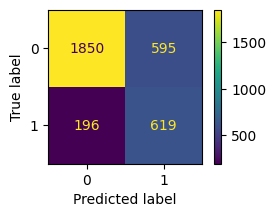

In [13]:
# Train model
logreg = LogisticRegression(class_weight='balanced', random_state=2022, max_iter=1000)
y_pred_logreg, f1_logreg, recall_logreg = fit_clf_and_results(X_train, X_val, y_train, y_val, logreg)

### K-Nearest-Neighbors

KNeighborsClassifier(n_neighbors=12, p=1, weights='distance') 
F1 score on the X_val is: 0.6321989528795812

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2445
           1       0.68      0.59      0.63       815

    accuracy                           0.83      3260
   macro avg       0.77      0.75      0.76      3260
weighted avg       0.82      0.83      0.82      3260



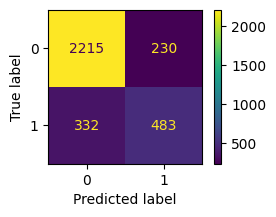

In [14]:
# Train model
knn = KNeighborsClassifier(n_neighbors=12, weights='distance', p=1)
y_pred_knn, f1_knn, recall_knn = fit_clf_and_results(X_train, X_val, y_train, y_val, knn)

### Support Vector Machine

SVC(C=2, class_weight='balanced', random_state=2022) 
F1 score on the X_val is: 0.686857760951866

              precision    recall  f1-score   support

           0       0.92      0.84      0.88      2445
           1       0.61      0.78      0.69       815

    accuracy                           0.82      3260
   macro avg       0.77      0.81      0.78      3260
weighted avg       0.84      0.82      0.83      3260



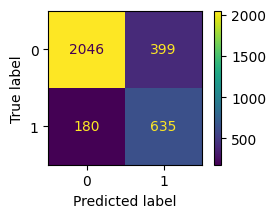

In [15]:
# Train model
svm = SVC(C=2, class_weight='balanced', random_state=2022)
y_pred_svm, f1_svm, recall_svm = fit_clf_and_results(X_train, X_val, y_train, y_val, svm)

## Ensemble Methods

Combining several models to archive better results than just by using a single model. However, this makes the model more complex, more time consuming to train and less understandable.

### Histogram Gradient Boosting

The histogram gradient boosting turned out to perform better than Random Forest and normal gradient boosting, therefore only this model is shown here.

HistGradientBoostingClassifier(max_depth=20, max_iter=1000, max_leaf_nodes=50,
                               random_state=2022, scoring='f1') 
F1 score on the X_val is: 0.6742934051144011

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      2445
           1       0.75      0.61      0.67       815

    accuracy                           0.85      3260
   macro avg       0.81      0.77      0.79      3260
weighted avg       0.85      0.85      0.85      3260



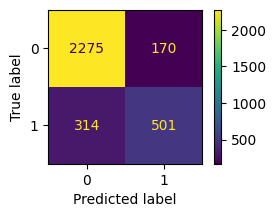

In [16]:
gb = HistGradientBoostingClassifier(max_leaf_nodes=50, max_depth=20, max_iter=1000, scoring='f1', random_state=2022)
y_pred_gb, f1_gb, recall_gb = fit_clf_and_results(X_train, X_val, y_train, y_val, gb)

### Stacked Estimators

The hyperparameters used here were found using try and error.

StackingClassifier(estimators=[('lr_bal',
                                LogisticRegression(class_weight='balanced',
                                                   max_iter=1000,
                                                   random_state=2022)),
                               ('knn',
                                KNeighborsClassifier(n_neighbors=13, p=1,
                                                     weights='distance')),
                               ('svm_bal',
                                SVC(C=1, class_weight='balanced',
                                    random_state=2022)),
                               ('gb',
                                HistGradientBoostingClassifier(max_depth=20,
                                                               max_iter=500,
                                                               max_leaf_nodes=59,
                                                               random_state=2022))],
                   final_estima

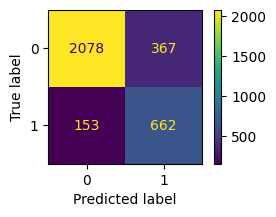

In [17]:
estimators = [
    ('lr_bal', LogisticRegression(class_weight='balanced', random_state = 2022, max_iter=1000)),
    ('knn', KNeighborsClassifier(n_neighbors=13, weights='distance', p=1)),
    ('svm_bal', SVC(C=1, class_weight='balanced', random_state=2022)),
    ('gb', HistGradientBoostingClassifier(max_leaf_nodes=59, max_depth=20, max_iter=500, random_state=2022)),
    ]

final_est = LogisticRegression(class_weight='balanced', random_state = 42)

stack_clf = StackingClassifier(estimators=estimators, final_estimator=final_est)
y_pred_stack_clf, f1_stack_clf, recall_stack_clf = fit_clf_and_results(X_train, X_val, y_train, y_val, stack_clf)

In [18]:
# Predict on test set
y_test_stack = stack_clf.predict(X_test)
y_test_stack

array([1, 0, 0, ..., 0, 0, 1])

## Submission file

Creating and saving the submission file for the challenge.

In [19]:
# df_y_test = pd.DataFrame(y_test_stack, columns=['Label'])
# y_submission = pd.concat([test['Sample_ID'],df_y_test], axis=1)
# y_submission.to_csv('data/submission_stack.csv',index=False)

## Analysing the Results

The stacking classifier shows best results for both the f1-score and the recall-score. The second best classifier is svm. 

Logistic regression, smv and stacking classifier all show good recall scores. They classify the true positives best. However, they have big weeknesses with the false positive values. These weaknesses are reduced with stacking the classifiers. As it is best to find as many landslides as possible with this model, it might be ok to manually check some more places without a landslide.

In [20]:
classifiers = ['logreg', 'knn', 'svm', 'gb', 'stacked']
f1_scores = [f1_logreg, f1_knn, f1_svm, f1_gb, f1_stack_clf]
recall_scores = [recall_logreg, recall_knn, recall_svm, recall_gb, recall_stack_clf]

[Text(0.5, 1.0, 'recall score'), (0.5, 1.0)]

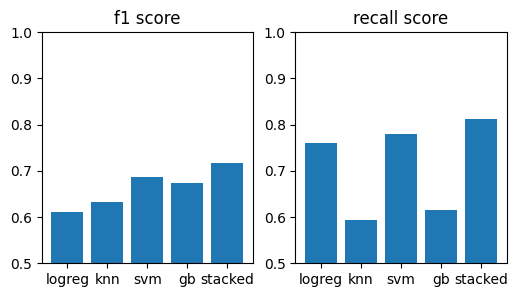

In [21]:
fig, axs = plt.subplots(1,2, figsize = (6, 3))
axs[0].bar(classifiers, f1_scores)
axs[1].bar(classifiers, recall_scores)
axs[0].set(title='f1 score', ylim=[0.5,1])
axs[1].set(title='recall score', ylim=[0.5,1])

### Stacking Classifier

The results of the best classifier, the stacked classifier, are analysed to find out the difficulties of the classification.

First the results of the validation set are classified using the true label as 'true negatives', 'true positives', 'false positives' and 'false negatives'. Then some plots are shown with the classification used as hue.

For some features like slope and lsfactor, the false negatives are mostly at values where the true positives are less likely. For other features, the false negatives show the same distribution as the true positives.

The false positives usually show the same distribution as the true positives.

In [22]:
def add_result_column(val_df, y_pred, classifier):
    y_pred_df = pd.DataFrame(y_pred, columns=['Label_pred']).set_index(val_df.index)
    
    conditions = [
    val_df['Label'].eq(0) & y_pred_df['Label_pred'].eq(0),
    val_df['Label'].eq(1) & y_pred_df['Label_pred'].eq(0),
    val_df['Label'].eq(0) & y_pred_df['Label_pred'].eq(1),
    val_df['Label'].eq(1) & y_pred_df['Label_pred'].eq(1)
    ]

    choices = ['TN','FN','FP','TP']

    val_df['Result_'+classifier] = np.select(conditions, choices, default=0)
    return val_df

In [23]:
# Calculating classifications for the best classifier to analyse the results
val_df = pd.concat([pd.DataFrame(X_val, columns=selected_cols).set_index(y_val.index), y_val], axis=1)
results_df = add_result_column(val_df, y_pred_stack_clf, 'Stack')

In [24]:
# Calculating relative values of geology for better visibility
geology = results_df.value_counts(subset=['13_geology', 'Result_Stack'], sort=False).reset_index(name="count")
geology_sum = results_df.value_counts('13_geology', sort=False).reset_index(name="sum")
geology_full = geology.merge(geology_sum, on='13_geology')
geology_full['rel'] = geology_full['count']/geology_full['sum']

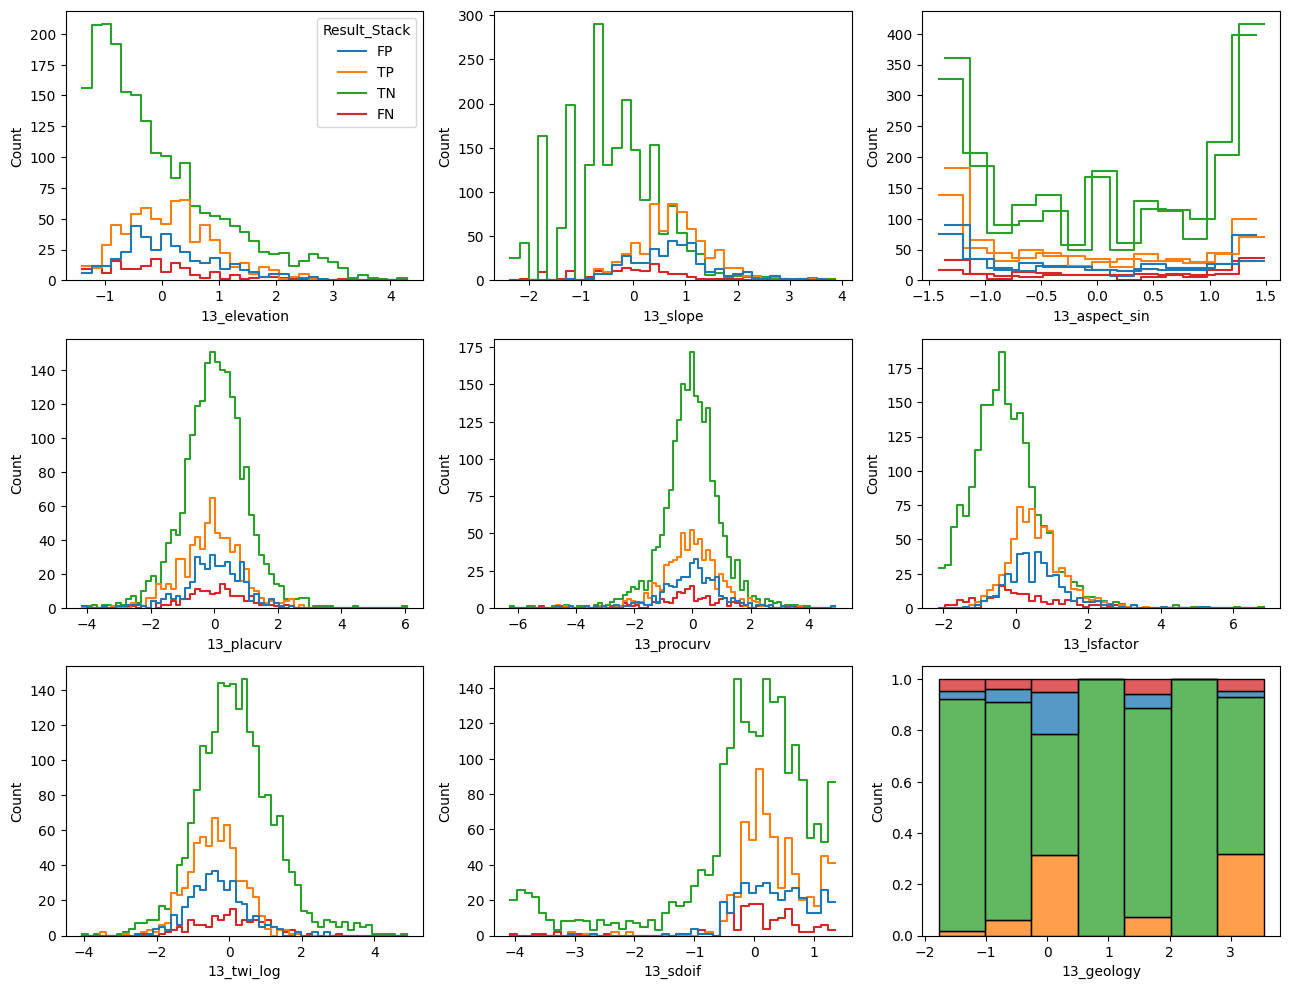

In [25]:
fig, axs = plt.subplots(3, 3, figsize = (13, 10))
classifier = 'Stack'
color_palette = {'TN': 'tab:green', 'TP': 'tab:orange', 'FP': 'tab:blue', 'FN': 'tab:red'}
sns.histplot(results_df, x="13_elevation", hue="Result_"+classifier, ax=axs[0,0], element="step", fill=False, palette=color_palette)
sns.histplot(results_df, x="13_slope", hue="Result_"+classifier, ax=axs[0,1], element="step", fill=False, legend=False, palette=color_palette)
sns.histplot(results_df, x="13_aspect_sin", hue="Result_"+classifier, ax=axs[0,2], element="step", fill=False, legend=False, palette=color_palette)
sns.histplot(results_df, x="13_aspect_cos", hue="Result_"+classifier, ax=axs[0,2], element="step", fill=False, legend=False, palette=color_palette)
sns.histplot(results_df, x="13_placurv", hue="Result_"+classifier, ax=axs[1,0], element="step", fill=False, legend=False, palette=color_palette)
sns.histplot(results_df, x="13_procurv", hue="Result_"+classifier, ax=axs[1,1], element="step", fill=False, legend=False, palette=color_palette)
sns.histplot(results_df, x="13_lsfactor", hue="Result_"+classifier, ax=axs[1,2], element="step", fill=False, legend=False, palette=color_palette)
sns.histplot(results_df, x="13_twi_log", hue="Result_"+classifier, ax=axs[2,0], element="step", fill=False, legend=False, palette=color_palette)
sns.histplot(results_df, x="13_sdoif", hue="Result_"+classifier, ax=axs[2,1], element="step", fill=False, legend=False, palette=color_palette)
sns.histplot(geology_full, x="13_geology", hue="Result_"+classifier, weights='rel', bins=7, ax=axs[2,2], multiple="stack", fill=True, legend=False, palette=color_palette)

fig.tight_layout()
plt.show()

In [26]:
markers = {'TN': '.', 'TP': '.', 'FP': '<', 'FN': '>'}

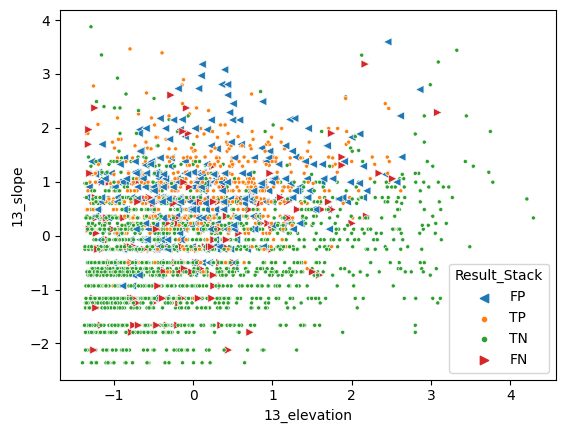

In [27]:
sns.scatterplot(x='13_elevation', y='13_slope', data=results_df, hue='Result_Stack', 
                style='Result_Stack', markers=markers);

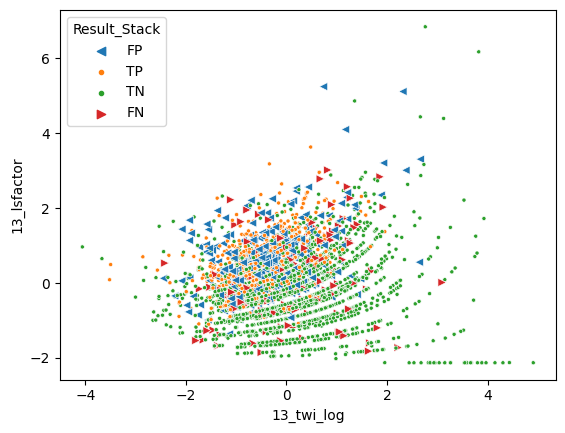

In [28]:
sns.scatterplot(x='13_twi_log', y='13_lsfactor', data=results_df, hue='Result_Stack', 
                style='Result_Stack', markers=markers);

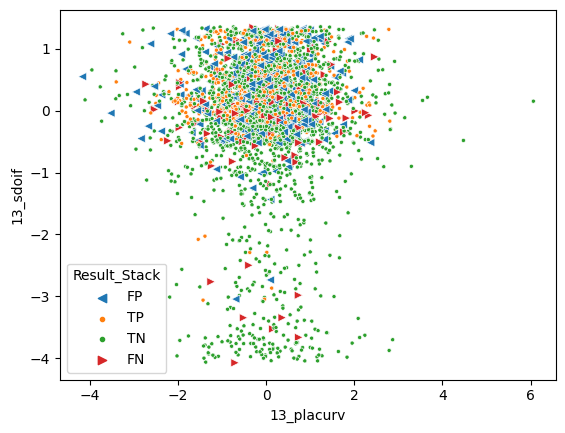

In [29]:
sns.scatterplot(x='13_placurv', y='13_sdoif', data=results_df, hue='Result_Stack', 
                style='Result_Stack', markers=markers);